# This notebook sets up the augmented single cell RNA-seq data and bulk data for use with training, 
## Performs:
- Intersection of genes
- Normalization
- Encoding of Metadata
- Collecting all the pieces, wrapping into a object and export as a single file for convenient re-use

In [1]:
import joblib
import sys
import pathlib
import yaml
import subprocess
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from matplotlib_venn import venn2, venn3

## Metadata Column Definition

In [2]:
STUDY_GEO_ID = 'GSE154600'

CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

## Import Local Packages

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.append(str(REPO_ROOT))
sys.path.append(str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from analysis_utils.buddi4data import BuDDI4Data
from buddi_v2.preprocessing.sc_augmentor import load_sc_augmentation_dir
from buddi_v2.plotting.plot_data import plot_data

2025-05-01 15:42:39.583379: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 15:42:39.591800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746135759.600751 1554651 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746135759.603523 1554651 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746135759.611134 1554651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Define paths to Input Files/Output

### Input from Pre-Processing

In [5]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data' 
assert PREPROCESSING_OUTPUT_PATH.exists(), f"Preprocessing output path {PREPROCESSING_OUTPUT_PATH} does not exist"

SC_AUGMENTED_DATA_PATH = PREPROCESSING_OUTPUT_PATH / 'sc_augmented' / f'{STUDY_GEO_ID}_augmented'
assert SC_AUGMENTED_DATA_PATH.exists(), f"Single cell augmented data path {SC_AUGMENTED_DATA_PATH} does not exist"
pseudobulk_files = list(SC_AUGMENTED_DATA_PATH.glob('*_splits.pkl'))
assert len(pseudobulk_files) > 0, f"No pseudobulk files found in {SC_AUGMENTED_DATA_PATH}"

BULK_FORMAT_DATA_PATH = PREPROCESSING_OUTPUT_PATH / 'bulk_formatted'
assert BULK_FORMAT_DATA_PATH.exists(), f"Bulk format data path {BULK_FORMAT_DATA_PATH} does not exist"
formatted_bulk_files = list(BULK_FORMAT_DATA_PATH.glob('*.h5ad'))
assert len(formatted_bulk_files) > 0, f"No formatted bulk files found in {BULK_FORMAT_DATA_PATH}"

### Input Cibersortx signature gene file 

In [6]:
## (TODO this is really ugly, maybe the data path should have a dedicated path to cibersortx output)?
CIBERSORTX_SIG_GENE_FILE = pathlib.Path(config_dict['data_path']['sc_data_path']) /\
    'GSE154600_cibersortx_output' /\
    'CIBERSORTx_Job4_GSM4675273_cibersortx_sc_reference_input_inferred_phenoclasses.CIBERSORTx_Job4_GSM4675273_cibersortx_sc_reference_input_inferred_refsample.bm.K999.txt'
assert CIBERSORTX_SIG_GENE_FILE.exists(), f"CIBERSORTx signature gene file not found at {CIBERSORTX_SIG_GENE_FILE}"

cibersortx_sig_df = pd.read_csv(CIBERSORTX_SIG_GENE_FILE, sep='\t', header=0)
cibersortx_sig_genes = cibersortx_sig_df['NAME'].values.tolist()
print(f"{len(cibersortx_sig_genes)} signature genes from CIBERSORTx")

2892 signature genes from CIBERSORTx


## Load Preprocessed Data

### Read gene id metadata files for both sc pseudobulk and real bulk and find interesection

Number of bulk genes: 18509
Number of single cell genes: 24520
Number of genes in intersection of single cell and bulk: 15836


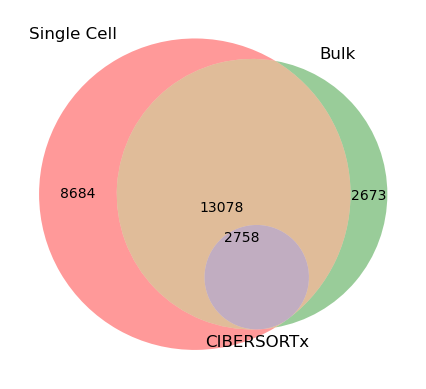

In [7]:
bulk_gene_file = BULK_FORMAT_DATA_PATH.glob('*.pkl')
bulk_gene_file = list(bulk_gene_file)[0]
bulk_genes = pd.read_pickle(bulk_gene_file)
print(f"Number of bulk genes: {len(bulk_genes)}")

sc_gene_file = SC_AUGMENTED_DATA_PATH / 'genes.pkl'
sc_genes = pd.read_pickle(sc_gene_file)
print(f"Number of single cell genes: {len(sc_genes)}")

# Intersect the genes
sc_bulk_intersection_genes = set(sc_genes) & set(bulk_genes)
sc_bulk_intersection_genes = list(sc_bulk_intersection_genes)
print(f"Number of genes in intersection of single cell and bulk: {len(sc_bulk_intersection_genes)}")

# drop cibersortx signature genes that are not in the sc bulk intersection
cibersortx_sig_genes = set(cibersortx_sig_genes).intersection(sc_bulk_intersection_genes)
cibersortx_sig_genes = list(cibersortx_sig_genes)

# Visualize the raw overlap of genes
venn3(
    [
        set(sc_genes),
        set(bulk_genes),
        set(cibersortx_sig_genes)
    ],
    set_labels=['Single Cell', 'Bulk', 'CIBERSORTx']
)

### Load Processed Bulk

In [8]:
processed_bulk = sc.read(formatted_bulk_files[0]) 

bulk_sample_ids = processed_bulk.obs[SAMPLE_ID_COL].unique()
n_bulk_samples = len(bulk_sample_ids)
print(f"Number of bulk samples: {n_bulk_samples}")

bulk_stims = processed_bulk.obs[STIM_COL].unique()
n_bulk_stims = len(bulk_stims)
print(f"Number of bulk stims: {n_bulk_stims}")

## Subset the bulk data to only include the intersection genes
processed_bulk = processed_bulk[
    :, 
    processed_bulk.var[GENE_ID_COL].isin(sc_bulk_intersection_genes)]

X_bulk_train = pd.DataFrame(
    processed_bulk.X,
    index=processed_bulk.obs[SAMPLE_ID_COL],
    columns=processed_bulk.var[GENE_ID_COL]
)

# Add metadata columns 
meta_bulk_train = processed_bulk.obs.loc[:,[SAMPLE_ID_COL, STIM_COL]]
meta_bulk_train[TECH_COL] = 'bulk'
meta_bulk_train[DATASPLIT_COL] = 'Train'
meta_bulk_train['cell_prop_type'] = 'bulk'
meta_bulk_train['cell_type'] = 'bulk'

Number of bulk samples: 588
Number of bulk stims: 2


### Load sc Pseudobulk

In [9]:
X_sc, Y_sc, meta_sc_df = load_sc_augmentation_dir(
    SC_AUGMENTED_DATA_PATH
)
X_sc = X_sc.loc[:, sc_bulk_intersection_genes]
if DATASPLIT_COL not in meta_sc_df.columns:
    meta_sc_df[DATASPLIT_COL] = 'Train'
train_idx = np.where(meta_sc_df[DATASPLIT_COL] == 'Train')[0]
meta_sc_df.head()

,sample_id,stim,cell_prop_type,cell_type,samp_type,isTraining
0,Samp-T59,white,random,random,sc_ref,Test
1,Samp-T59,white,random,random,sc_ref,Test
2,Samp-T59,white,random,random,sc_ref,Test
3,Samp-T59,white,random,random,sc_ref,Test
4,Samp-T59,white,random,random,sc_ref,Test


## Format Data
### Concatenate X, Y

In [10]:
# Generate place holder for bulk proportion 
# (not used but needed to maintain matching dataset dimensions)
# Eventually these dummy zero values will be returned as target values for training but the loss function
# for unsupervised model training will ignore them
Y_bulk_dummy = pd.DataFrame(
    np.zeros((X_bulk_train.shape[0], Y_sc.shape[1])),
    columns=Y_sc.columns
)

X_concat = pd.concat([X_bulk_train, X_sc])
Y_concat = pd.concat([Y_bulk_dummy, Y_sc])
meta_concat = pd.concat([meta_bulk_train, meta_sc_df])

# save gene and cell type names
X_gene_names = X_concat.columns.to_list()
Y_cell_type_names = Y_concat.columns.to_list()

### Gene Feature Selection

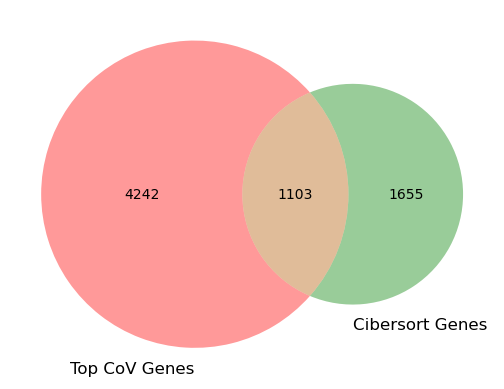

(11088, 7000)


In [11]:
## get the top variable genes
X_colmean = X_concat.values.mean(axis=0) # mean across samples
X_colvar = X_concat.values.var(axis=0) # variance across samples
# coefficient of variation which is the var to mean ratio
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001)) 

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False

gene_df = pd.DataFrame(X_gene_names, columns=['gene'])

# start with top 7000 genes by CoV
initial_count = 7000
while not num_genes_found:
    # retrieve the top initial_count genes by CoV
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    # get gene names from idx_top
    top_gene_df = gene_df.iloc[idx_top]

    # produce the union of the top genes and the cibersort genes
    CoV_only = np.union1d(top_gene_df, cibersortx_sig_genes)

    # check if the union is 7000
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        # if not decrement the top CoV gene to retrieve by 1
        # in the next iteration, there will be two possibilities
        # 1. the union will have one less gene due to the removed gene being only in the CoV genes
        # 2. the union will have the same number of genes as this iteration due to the removed 
        #    gene being also present in CIBERSORTx genes
        # keep running this loop until the union has 7000 genes
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]
venn2([set(gene_df.values.flatten()), 
       set(cibersortx_sig_genes)], 
       set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

feature_select_genes = np.union1d(gene_df, cibersortx_sig_genes)

# to numpy matrix
X = X_concat.loc[:,feature_select_genes].to_numpy()
print(X.shape)

Y = Y_concat.to_numpy()

### Encode Metadata

In [12]:
FIELDS_TO_ENCODE = [SAMPLE_ID_COL, STIM_COL, TECH_COL]

encoded = {}

for field in FIELDS_TO_ENCODE:
    encoder = OneHotEncoder(dtype=int)
    encoded[field] = pd.DataFrame(
        encoder.fit_transform(meta_concat.loc[:,[field]]).toarray(),
        columns=encoder.get_feature_names_out([field])
    )

## Expression Normalization

In [13]:
# Library size normalization
expected_libsizes = 1e6

libsizes = np.sum(X, axis=1, keepdims=True)
libsizes[libsizes == 0] = 1
X_norm = X / libsizes * expected_libsizes

## normalize within sample
clip_upper = np.quantile(X_norm, 0.9)
X_norm = np.clip(X_norm, 0, clip_upper)

## MinMax scaling
scaler = MinMaxScaler()
scaler.fit(X_norm)
X_norm = scaler.transform(X_norm)

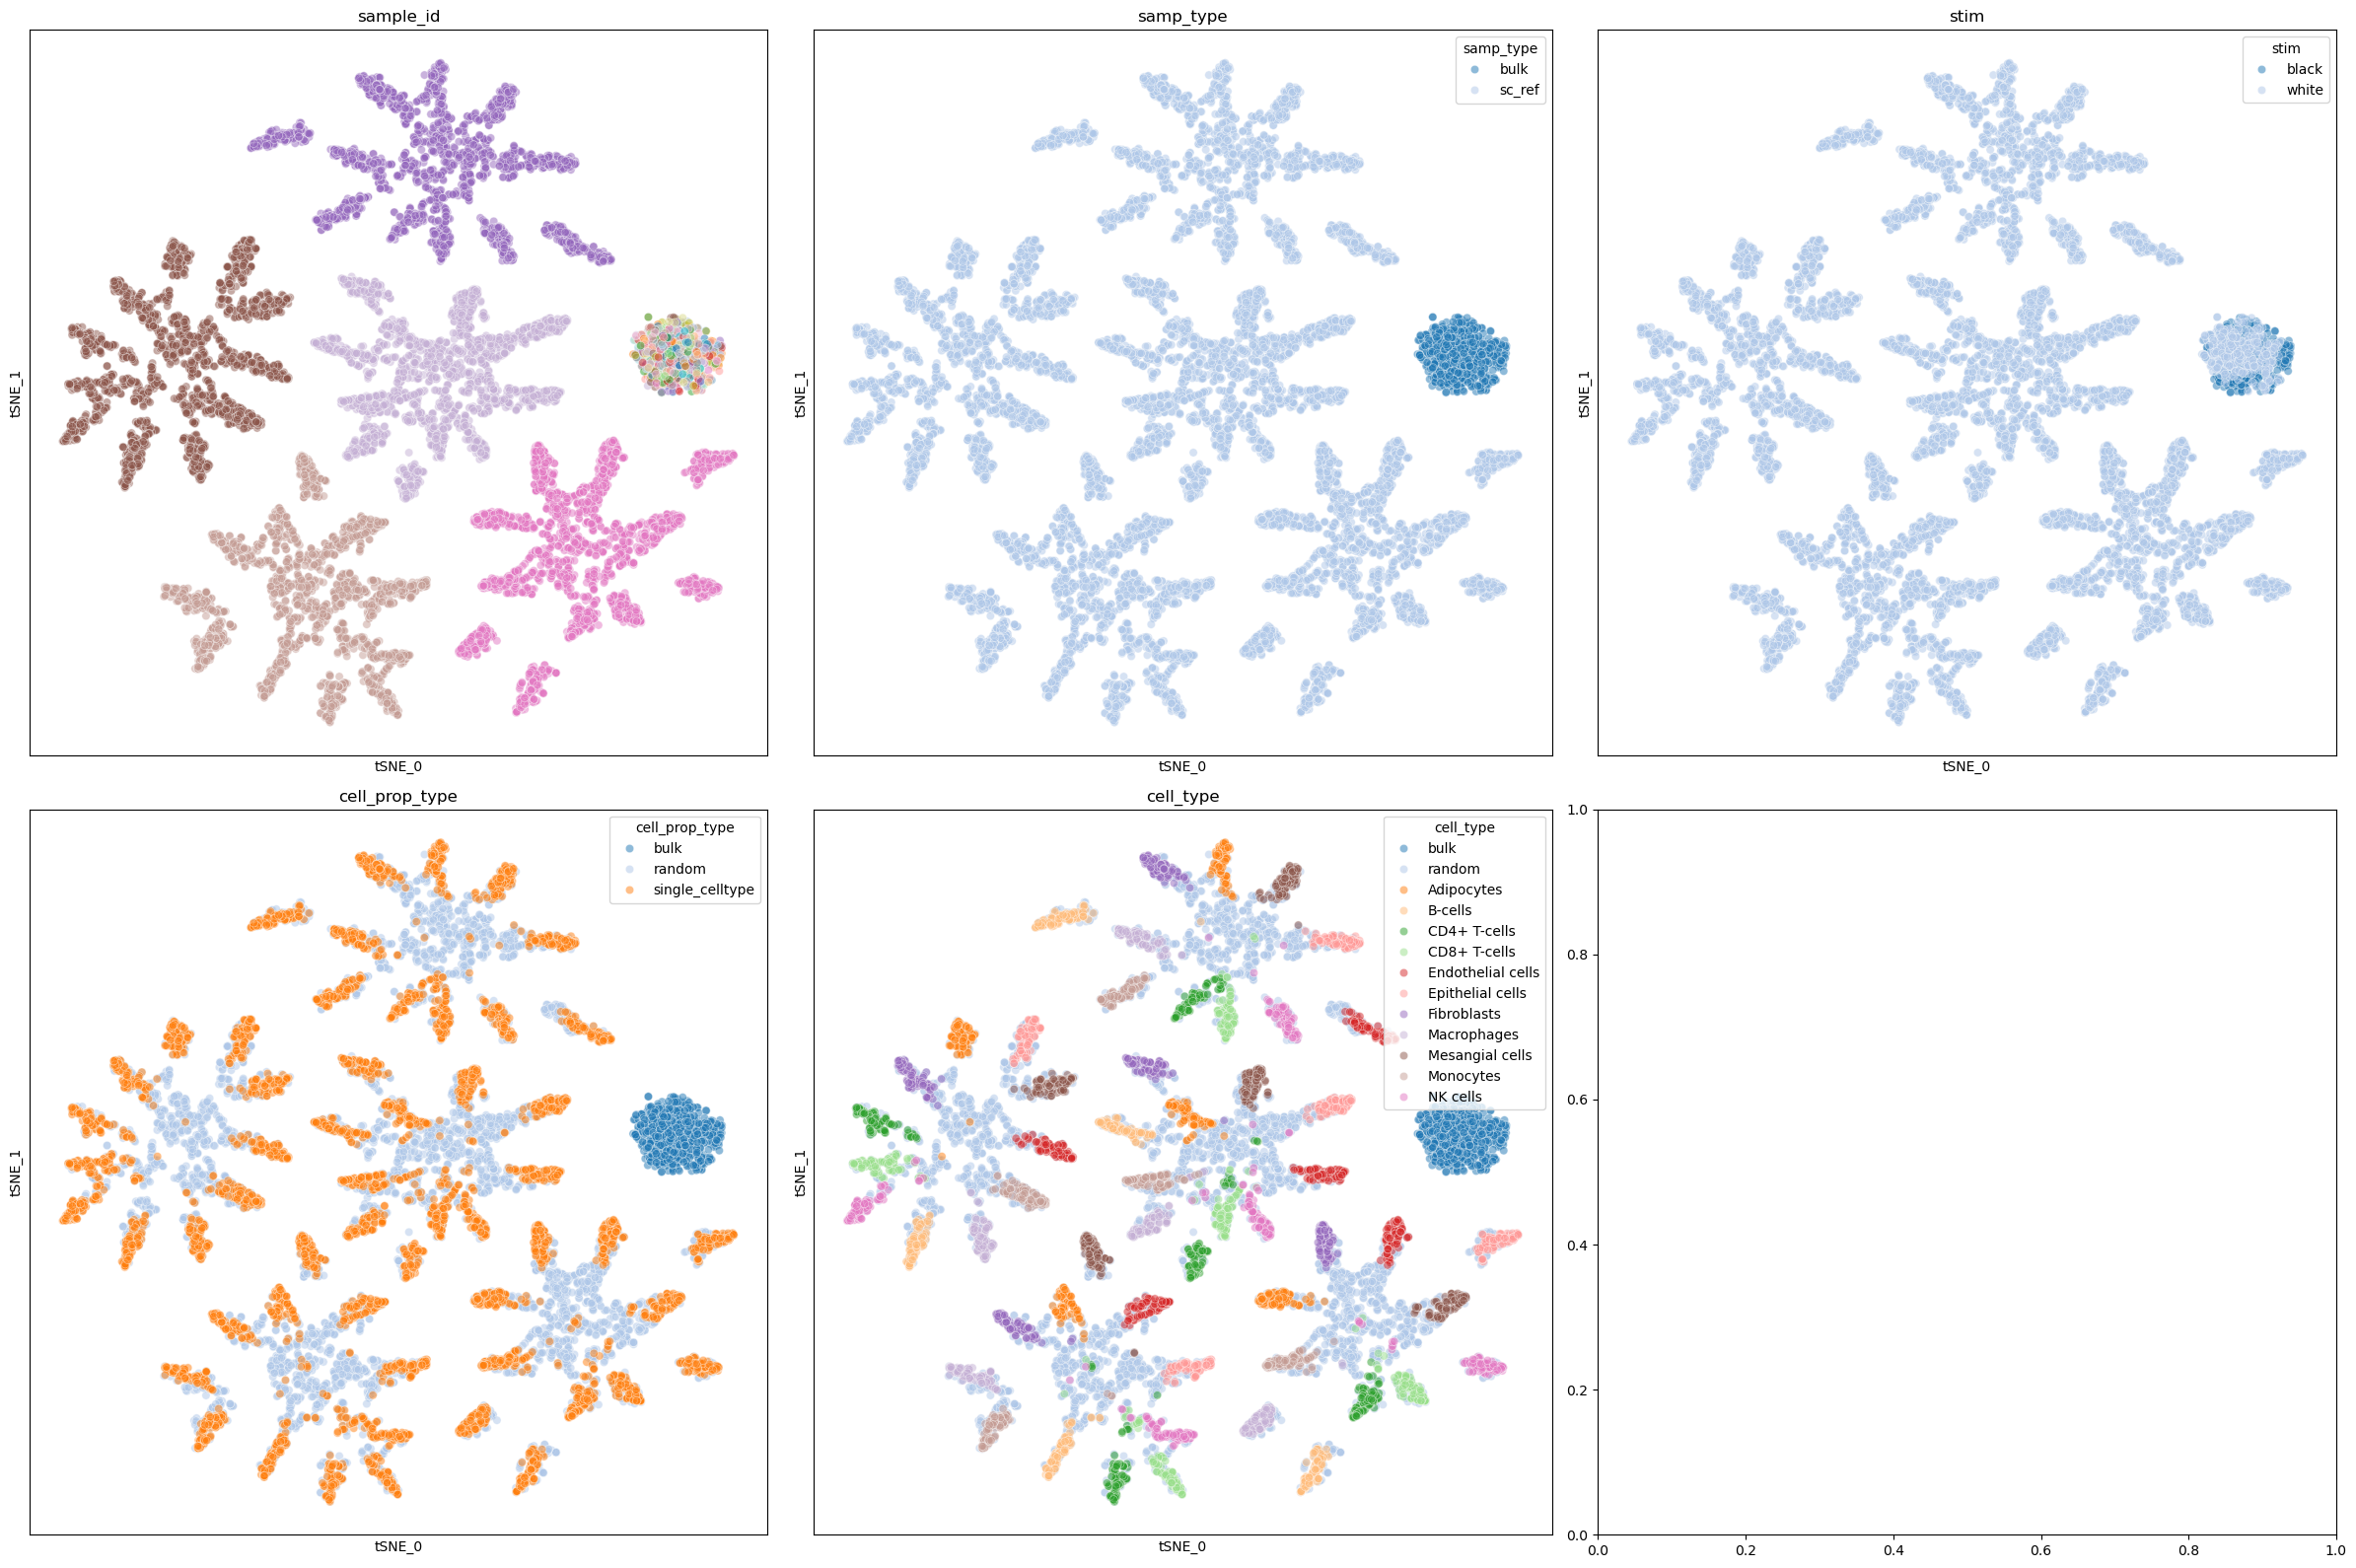

In [14]:
plot_data(
    X_norm,
    meta_concat,
    panel_width=8,
    show_plot=True
)

### Supervised vs Unsupervised split

In [15]:
idx_train = np.where(meta_concat[DATASPLIT_COL]=="Train")[0] 
idx_bulk = np.where(meta_concat[TECH_COL] == "bulk")[0]
idx_sc = np.where(meta_concat[TECH_COL] != "bulk")[0]

# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train)
np.random.shuffle(idx_bulk_train) # shuffle the indices randomly

X_unkp = X_norm[idx_bulk_train,]
label_unkp = encoded[SAMPLE_ID_COL].values[idx_bulk_train,]
drug_unkp = encoded[STIM_COL].values[idx_bulk_train,]
bulk_unkp = encoded[TECH_COL].values[idx_bulk_train,]
y_unkp = Y[idx_bulk_train,]

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train)
np.random.shuffle(idx_sc_train) # shuffle the indices randomly

X_kp = X_norm[idx_sc_train,]
label_kp = encoded[SAMPLE_ID_COL].values[idx_sc_train,]
drug_kp = encoded[STIM_COL].values[idx_sc_train,]
bulk_kp = encoded[TECH_COL].values[idx_sc_train,]
y_kp = Y[idx_sc_train,]

meta_kp = meta_concat.iloc[idx_sc_train,:]
meta_unkp = meta_concat.iloc[idx_bulk_train,:]

## Dump Formatted Train Data

In [16]:
train_data = BuDDI4Data(
    X_unkp=X_unkp,
    y_unkp=y_unkp,
    label_unkp=label_unkp,
    stim_unkp=drug_unkp,
    samp_type_unkp=bulk_unkp,
    X_kp=X_kp,
    y_kp=y_kp,
    label_kp=label_kp,
    stim_kp=drug_kp,
    samp_type_kp=bulk_kp,
    meta_kp=meta_kp,
    meta_unkp=meta_unkp,
    gene_names=feature_select_genes,
    cell_type_names=Y_cell_type_names,
    encode_meta=encoded
)
train_data

BuDDIData(unkp_samples=588, kp_samples=8400, genes=7000, cell_types=11)

In [17]:
joblib.dump(
    train_data, 
    PREPROCESSING_OUTPUT_PATH / "buddi4_train_data.pkl")

['/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/processed_data/buddi4_train_data.pkl']